In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numpy import pi

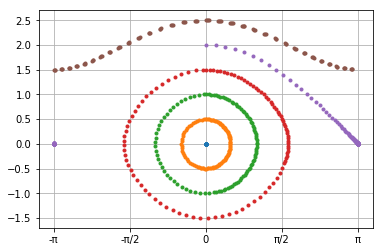

In [41]:
from scipy.integrate import ode
from numpy import *


def f(t, Y):
    y, yprime=Y
    return array([yprime, -sin(y)])



T = 10
N = 100
temps = np.arange(100)*T/N


Tv0 = np.array([0, .5, 1, 1.5, 2, 2.5])

def my_modulo_2pi(theta):
    return (theta + np.pi)%(2*np.pi) - np.pi

for v0 in Tv0:

    res = np.zeros((100, 2))
    res[0, :] = (0, v0)

    r = ode(f).set_integrator('vode')
    r.set_initial_value(res[0,:],0)

    for i in range(1, N):
        res[i, :] = r.integrate(temps[i])
    plt.plot(my_modulo_2pi(res[:,0]), res[:,1], '.')

ax = plt.gca()
ticks = np.array([-1, -.5, 0, .5, 1])
ax.xaxis.set_ticks(ticks*pi)
ax.xaxis.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

ax.grid()

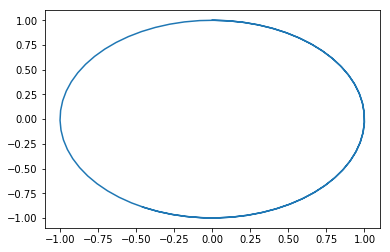

## Ions

In [98]:
N = 50

p_x = np.random.normal(size=N)
p_y = np.random.normal(size=N)

v_x = np.random.normal(size=N)
v_y = np.random.normal(size=N)


p_0 = np.array([p_x, p_y])
v_0 = np.array([v_x, v_y])

Y0 = np.array([p_0, v_0])


m = np.ones(N)*9
q = np.ones(N)

k_x = 1
k_y = .5

k = np.array([k_x, k_y])

In [103]:

force(p_0, v_0)[:, 0], p_0[:,0]

(array([-0.05828915,  0.4617505 ]), array([ 0.05828915, -0.92350099]))

(200,)

In [341]:
import numbers
import numba

@numba.jit(nopython=True)
def force_potentielle(p, k):
    return -p*k.reshape(-1, 1)# [:,np.newaxis]

@numba.jit(nopython=True)
def force_friction(v, alpha):
    return -v*alpha

# This is the critical part (scale as N**2)
# For better efficiency, you need to unwrap all the loop
@numba.jit(nopython=True)
def force_coulomb(p, q):
    N = len(q)
    res = np.zeros((2, N))
    tmp = np.zeros((2, N, N))
    r_ij = np.zeros((2,))
    for i in range(N):
        for j in range(i+1, N):
            for k in range(2):
                r_ij[k] = p[k,i] - p[k,j]
            r2 = r_ij[0]*r_ij[0] + r_ij[1]*r_ij[1]
            r3 = np.sqrt(r2)*r2
            c = q[j]*q[i]/r3
            for k in range(2):
                tmp[k, i, j] = c*r_ij[k]
                res[k,i] += tmp[k, i, j]
    for i in range(N):
        for j in range(i):
            for k in range(2):
                res[k, i] -= tmp[k, j, i]
            
    return res

@numba.jit(nopython=True)
def force(p, v, k, alpha, q):
    return force_potentielle(p, k) + force_friction(v, alpha) + force_coulomb(p, q)

#@numba.jit(nopython=True)
def f(t, Y, k, m, q, alpha):
    """ 
    
    Y : tableau de taille 4*N ou (2, 2, N): (position/vitesse, ux/uy, N particules)
    
    variables globales : 
    N
    m : tableau de taille N, masse des particules
    
    """
    N = len(Y)//4
    tmp_Y = Y.reshape((2, 2, N))
    p = tmp_Y[0]
    v = tmp_Y[1]

    acceleration = force(p, v, k, alpha, q)/m
    Ydot = np.zeros((2, 2, N))
    Ydot[0] = v
    Ydot[1] = acceleration
    return Ydot.flatten()
    



class Simulation(object):
    k_x = 1
    k_y = .5
    def __init__(self, p_0, v_0, m, q, alpha=0.03):
        self.p_0 = p_0
        self.v_0 = v_0
        self.N = p_0.shape[1]
        self.m = m
        self.q = q
        if isinstance(alpha, numbers.Number):
            alpha = np.ones(self.N)*alpha
        self.alpha = alpha
        
    @property
    def k(self):
        return np.array([self.k_x, self.k_y])
        
    @property
    def Y0(self):
        return np.array([self.p_0, self.v_0])
        
    def simulate(self, temps):
        self.temps = temps
        N_t = len(temps)
        res = np.zeros((N_t, 2, 2, self.N))
        res[0] = self.Y0

        r = ode(f).set_integrator('vode')
        r.set_f_params(self.k, self.m, self.q, self.alpha)
        r.set_initial_value(res[0].flatten(), 0)

        for i in range(1, N_t):
            res[i] = r.integrate(temps[i]).reshape((2, 2, self.N))

        self.res = res
        
    @property
    def position(self):
        """ Renvoie tableau de taille N_t, 2, N"""
        return self.res[:, 0, :, :]

    @property
    def position_x(self):
        return self.position[:,0, :]

    @property
    def position_y(self):
        return self.position[:,1, :]
    
    @property
    def vitesse(self):
        """ Renvoie tableau de taille N_t, 2, N"""
        return self.res[:, 1, :, :]    
    
    @property
    def vitesse_x(self):
        return self.vitesse[:,0, :]
    
    @property
    def vitesse_y(self):
        return self.vitesse[:,1, :]

    @property
    def energie(self):
        return (self.m*self.vitesse_x**2/2 + self.m*self.vitesse_y**2/2 + 
                self.k[0]*self.position_x**2/2 + self.k[1]*self.position_y**2/2)

    @property
    def energie_totale(self):
        return self.energie.sum(axis=1)
    
    def plot_trajectories(self):
        for i in range(self.N):
            plt.plot(self.position_x[:,i], self.position_y[:,i])
            
          


In [342]:
N = 1000

p_x = np.random.normal(size=N)
p_y = np.random.normal(size=N)

v_x = np.random.normal(size=N)
v_y = np.random.normal(size=N)


p_0 = np.array([p_x, p_y])
v_0 = np.array([v_x, v_y])


m = np.ones(N)*9
q = np.ones(N)


In [344]:
%timeit force(p_0, v_0, np.array([k_x, k_y]), np.ones(N)*0.01, q)

11.4 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [345]:
%timeit f(0, np.array([p_0, v_0]).flatten(), np.array([k_x, k_y]), m, q, np.ones(N)*0.01)

11.6 ms ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/home/pierre/sources/anaconda3/envs/enseignement/lib/python3.6/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 15min 20s, sys: 20 ms, total: 15min 20s
Wall time: 15min 20s


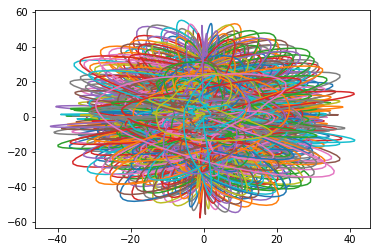

In [346]:
%%time
temps = np.arange(400)*0.5
simu = Simulation(p_0, v_0, m, q, alpha=0.5)
simu.simulate(temps)
simu.plot_trajectories()

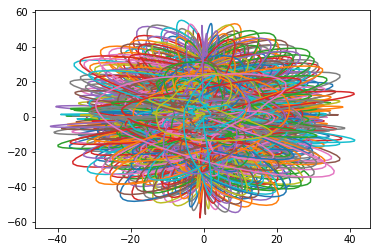

In [347]:
simu.plot_trajectories()

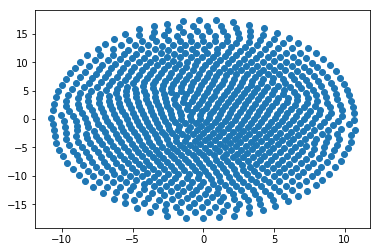

In [348]:
plt.plot(simu.position_x[-1,:], simu.position_y[-1,:], 'o')

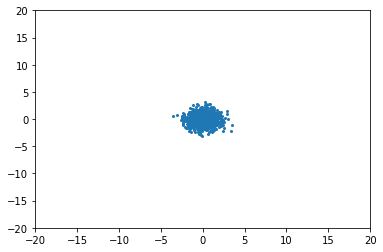

In [351]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig = plt.figure()

def animation(i):
    fig.clf()
    plt.plot(simu.position_x[i,:], simu.position_y[i,:], 'o', markersize=2)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    
anim = FuncAnimation(fig, animation, frames=399, interval=20)

HTML(anim.to_html5_video())